In [1]:
import symforce
symforce.set_epsilon_to_symbol()

In [2]:
import symforce.symbolic as sf
import numpy as np
from symforce.values import Values
from symforce import typing as T

In [3]:
# 3 satellites, 3 poses
num_poses = 3
num_satellites = 3

In [16]:
# Ground truth positions
x_pos = np.array([[3, 1, 0], [7, 4, 0], [11, 3, 0]])
s_pos = np.array([[-2, 7, 0], [13, 9, 0], [7, -6, 0]])

# Ground truth distances
ranges = np.zeros((num_satellites, num_poses))
for i in range(num_poses):
    for j in range(num_satellites):
        ranges[i,j] = np.linalg.norm(x_pos[i] - s_pos[j])

In [5]:
# Assume all rotations = I

In [17]:
# Store in values
initial_values = Values(
    world_T_body=[sf.Pose3.identity()] * num_poses,
    world_t_landmark=[sf.V3(s_pos[0]), sf.V3(s_pos[1]), sf.V3(s_pos[2])],
    odometry=[sf.Pose3(R = sf.Rot3(), t = sf.V3(4, 3, 0)), 
               sf.Pose3(R = sf.Rot3(), t = sf.V3(4, -1, 0))],
    ranges=ranges.tolist(),
    sigmas=sf.V6(1, 1, 1, 1, 1, 1),
    epsilon=sf.numeric_epsilon,
)

In [18]:
def range_residual(
    pose: sf.Pose3, satellite: sf.V3, range: sf.Scalar, epsilon: sf.Scalar
) -> sf.V1:
    return sf.V1((pose.t - satellite).norm(epsilon=epsilon) - range)

In [37]:
range_residual(sf.Pose3(R = sf.Rot3(), t = sf.V3(x_pos[0])), sf.V3(s_pos[0]), ranges[0,0], sf.numeric_epsilon)

[0]

In [11]:
# def odometry_residual(
#     pose_a: sf.Pose2, pose_b: sf.Pose2, odom: sf.Pose2, epsilon: sf.Scalar
# ) -> sf.V3:
#     pose_diff = pose_b.compose(pose_a.inverse())
#     return T.cast(sf.V3, pose_diff.compose(odom.inverse()))

In [19]:
def odometry_residual(
    world_T_a: sf.Pose3,
    world_T_b: sf.Pose3,
    a_T_b: sf.Pose3,
    diagonal_sigmas: sf.V6,
    epsilon: sf.Scalar,
) -> sf.V6:
    """
    Residual on the relative pose between two timesteps of the robot.
    Args:
        world_T_a: First pose in the world frame
        world_T_b: Second pose in the world frame
        a_T_b: Relative pose measurement between the poses
        diagonal_sigmas: Diagonal standard deviation of the tangent-space error
        epsilon: Small number for singularity handling
    """
    a_T_b_predicted = world_T_a.inverse() * world_T_b
    tangent_error = a_T_b_predicted.local_coordinates(a_T_b, epsilon=epsilon)
    return T.cast(sf.V6, sf.M.diag(diagonal_sigmas.to_flat_list()).inv() * sf.V6(tangent_error))

In [20]:
pose_a = sf.Pose3(R = sf.Rot3(), t = sf.V3(x_pos[0]))
pose_b = sf.Pose3(R = sf.Rot3(), t = sf.V3(x_pos[1]))
a_b = sf.Pose3(R = sf.Rot3(), t = sf.V3(4, 3, 0))
odometry_residual(pose_a, pose_b, a_b, sf.V6(1, 1, 1, 1, 1, 1), sf.numeric_epsilon)

[0]
[0]
[0]
[0]
[0]
[0]

In [21]:
pose_a.inverse() * pose_b

<Pose3 R=<Rot3 <Q xyzw=[0, 0, 0, 1]>>, t=(4, 3, 0)>

In [22]:
from symforce.opt.factor import Factor

factors = []

# Range factors
for i in range(num_poses):
    for j in range(num_satellites):
        factors.append(Factor(
            residual=range_residual,
            keys=[f"world_T_body[{i}]", f"world_t_landmark[{j}]", f"ranges[{i}][{j}]", "epsilon"],
        ))

# Odometry factors
for i in range(num_poses - 1):
    factors.append(Factor(
        residual=odometry_residual,
        keys=[f"world_T_body[{i}]", f"world_T_body[{i + 1}]", f"odometry[{i}]", "sigmas", "epsilon"],
    ))

In [23]:
from symforce.opt.optimizer import Optimizer

optimizer = Optimizer(
    factors=factors,
    optimized_keys=[f"world_T_body[{i}]" for i in range(num_poses)],
    # So that we save more information about each iteration, to visualize later:
    debug_stats=True,
)

In [24]:
result = optimizer.optimize(initial_values)

[2023-01-10 16:20:00.273] [info] LM<sym::Optimize> [iter    0] lambda: 1.000e+00, error prev/linear/new: 126.252/61.271/49.687, rel reduction: 0.60644
[2023-01-10 16:20:00.275] [info] LM<sym::Optimize> [iter    1] lambda: 2.500e-01, error prev/linear/new: 49.687/7.117/1.449, rel reduction: 0.97084
[2023-01-10 16:20:00.276] [info] LM<sym::Optimize> [iter    2] lambda: 6.250e-02, error prev/linear/new: 1.449/0.008/0.003, rel reduction: 0.99788
[2023-01-10 16:20:00.281] [info] LM<sym::Optimize> [iter    3] lambda: 1.562e-02, error prev/linear/new: 0.003/0.000/0.000, rel reduction: 0.99984
[2023-01-10 16:20:00.282] [info] LM<sym::Optimize> [iter    4] lambda: 3.906e-03, error prev/linear/new: 0.000/0.000/0.000, rel reduction: 0.99797
[2023-01-10 16:20:00.284] [info] LM<sym::Optimize> [iter    5] lambda: 9.766e-04, error prev/linear/new: 0.000/0.000/0.000, rel reduction: 0.00531
[2023-01-10 16:20:00.285] [info] LM<sym::Optimize> [iter    6] lambda: 2.441e-04, error prev/linear/new: 0.000/0.

In [25]:
for i, pose in enumerate(result.optimized_values["world_T_body"]):
        print(f"world_T_body {i}: t = {pose.position()}, R = {pose.rotation().to_tangent()}")

world_T_body 0: t = [[3.]
 [1.]
 [0.]], R = [[0.00000000e+00]
 [0.00000000e+00]
 [4.59496565e-14]]
world_T_body 1: t = [[7.]
 [4.]
 [0.]], R = [[0.00000000e+00]
 [0.00000000e+00]
 [1.72101357e-14]]
world_T_body 2: t = [[11.]
 [ 3.]
 [ 0.]], R = [[0.00000000e+00]
 [0.00000000e+00]
 [1.85282131e-14]]


In [26]:
# ----------------------------------------------------------------------------
# SymForce - Copyright 2022, Skydio, Inc.
# This source code is under the Apache 2.0 license found in the LICENSE file.
# ----------------------------------------------------------------------------

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import animation
from matplotlib.widgets import Slider

from symforce.opt.optimizer import Optimizer
from symforce.python_util import AttrDict
from symforce.values import Values


def plot_solution(
    optimizer: Optimizer,
    result: Optimizer.Result,
    animated: bool = False,
    show_iteration_text: bool = False,
) -> None:
    """
    Visualize the optimization problem along its iterations. If animated is True, displays a
    matplotlib animation instead of providing an interactive slider.
    """
    # Pull out values from the result
    values_per_iter = [
        optimizer.load_iteration_values(stats.values) for stats in result.iteration_stats
    ]

    # Create the layout
    fig = plt.figure()
    ax = plt.axes(projection="3d")
    ax.set_zlim3d(0, 11)
    ax.set_ylim3d(0, 11)
    ax.set_xlim3d(0, 11)
    plt.grid(True, alpha=0.5)
    plt.tight_layout()

    # Pull out quantities to plot
    data = get_data_to_plot(result.optimized_values)

    # Draw a circle at the origin
    ax.scatter3D([0], [0], [0], color="black", s=50, zorder=2)

    # Draw landmark locations
    ax.scatter3D(
        data.world_t_landmark[:, 0],
        data.world_t_landmark[:, 1],
        data.world_t_landmark[:, 2],
        color="orange",
        s=100,
        zorder=3,
    )

    # Draw poses
    poses_circles = [
        ax.scatter3D(
            data.world_t_body[:, 0],
            data.world_t_body[:, 1],
            data.world_t_body[:, 2],
            color="skyblue",
            zorder=3,
            s=100,
        )
    ]

    # Draw lines connecting poses
    poses_lines = ax.plot3D(
        data.world_t_body[:, 0],
        data.world_t_body[:, 1],
        data.world_t_body[:, 2],
        color="black",
        zorder=2,
        alpha=0.8,
    )

    # Draw dotted lines from poses to their landmark heading measurements
    dotted_style = dict(
        arrow_length_ratio=0.05,
        linestyle=":",
        linewidth=0.4,
        color="red",
        alpha=0.8,
        capstyle="butt",
    )
    # meas_arrows = [
    #     ax.quiver(
    #         data.world_t_body[:, 0],
    #         data.world_t_body[:, 1],
    #         data.world_t_body[:, 2],
    #         data.meas_vectors[:, landmark_inx, 0],
    #         data.meas_vectors[:, landmark_inx, 1],
    #         data.meas_vectors[:, landmark_inx, 2],
    #         **dotted_style,
    #     )
    #     for landmark_inx in range(data.meas_vectors.shape[1])
    # ]

    # Text box to write iteration stats
    if show_iteration_text:
        text = ax.text(8, 7, 9, "-", color="black")

    def update_plot(slider_value: np.float64) -> None:
        """
        Update the plot using the given iteration.
        """
        num = int(slider_value)

        # Set iteration text and abort if we rejected this iteration
        if show_iteration_text:
            stats = result.iteration_stats[num]
            if num > 0 and not stats.update_accepted:
                text.set_text(f"Iteration: {num} (rejected)\nError: {stats.new_error:.1f}")
                return
            text.set_text(f"Iteration: {num}\nError: {stats.new_error:.1f}")

        # Get plottable data for this iteration
        v = values_per_iter[num]
        data = get_data_to_plot(v)

        # Update the pose locations and connecting lines
        poses_circles[0].remove()
        poses_circles[0] = ax.scatter3D(
            data.world_t_body[:, 0],
            data.world_t_body[:, 1],
            data.world_t_body[:, 2],
            color="skyblue",
            zorder=3,
            s=100,
        )

        poses_lines[0].remove()
        poses_lines[0] = ax.plot3D(
            data.world_t_body[:, 0],
            data.world_t_body[:, 1],
            data.world_t_body[:, 2],
            color="black",
            zorder=2,
            alpha=0.8,
        )[0]

        # Update measurement vectors to landmarks
        # for landmark_inx in range(len(v["world_t_landmark"])):
        #     meas_arrows[landmark_inx].remove()
        #     meas_arrows[landmark_inx] = ax.quiver(
        #         data.world_t_body[:, 0],
        #         data.world_t_body[:, 1],
        #         data.world_t_body[:, 2],
        #         data.meas_vectors[:, landmark_inx, 0],
        #         data.meas_vectors[:, landmark_inx, 1],
        #         data.meas_vectors[:, landmark_inx, 2],
        #         **dotted_style,
        #     )

    if animated:
        ani = animation.FuncAnimation(
            fig, update_plot, len(values_per_iter), fargs=tuple(), interval=500
        )
        filename = "robot_3d_localization.mp4"
        ani.save(filename, dpi=200)
        print(f"Wrote to {filename}")
    else:
        # Add a slider for iterations at the bottom of the plot
        plt.subplots_adjust(bottom=0.2)
        ax_slider = plt.axes([0.25, 0.1, 0.65, 0.03])
        iteration_slider = Slider(
            ax=ax_slider,
            label="Iteration",
            valmin=0,
            valmax=len(values_per_iter) - 1,
            valinit=len(values_per_iter) - 1,
            valfmt="%0.0f",
        )
        iteration_slider.on_changed(update_plot)
        iteration_slider.set_val(len(values_per_iter) - 1)
        plt.show()


def get_data_to_plot(v: Values) -> AttrDict:
    """
    Compute direct quantities needed for plotting.
    """
    data = AttrDict()

    # Landmark positions
    data.world_t_landmark = np.array(v["world_t_landmark"])

    # Pose positions
    data.world_t_body = np.array([p.position() for p in v["world_T_body"]])

    # Pose axis vectors
    data.pose_x_axes = np.array([p.rotation() * np.array([1, 0, 0]) for p in v["world_T_body"]])
    data.pose_y_axes = np.array([p.rotation() * np.array([0, 1, 0]) for p in v["world_T_body"]])
    data.pose_z_axes = np.array([p.rotation() * np.array([0, 0, 1]) for p in v["world_T_body"]])

    # Measurement heading vectors from each pose to each landmark
    # data.meas_vectors = np.array(
    #     [
    #         [
    #             v["world_T_body"][i].rotation() * v["body_t_landmark_measurements"][i][j]
    #             for j in range(len(v["world_t_landmark"]))
    #         ]
    #         for i in range(len(v["world_T_body"]))
    #     ]
    # )

    return data

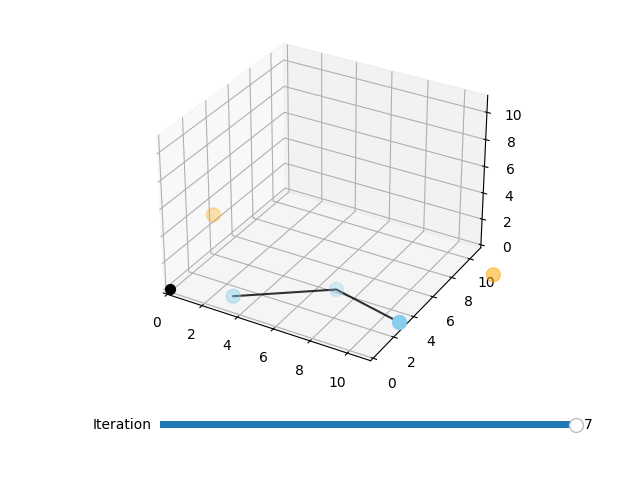

In [27]:
%matplotlib widget
plot_solution(optimizer, result, animated=False)